In [1]:
# from google.colab import drive
# drive.mount('/gdrive')

In [2]:
import os
import numpy as np
import tensorflow as tf

In [3]:
IMG_SIZE = 160

train_dataset = tf.keras.utils.image_dataset_from_directory(
    "./dog-cat-full-dataset-master/data/train", image_size=(IMG_SIZE, IMG_SIZE),
    validation_split=0.1, subset="training", shuffle=True,
    seed=42, batch_size=32
)

valid_dataset = tf.keras.utils.image_dataset_from_directory(
    "./dog-cat-full-dataset-master/data/train", image_size=(IMG_SIZE, IMG_SIZE),
    validation_split=0.1, subset="validation", shuffle=True,
    seed=42, batch_size=32
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    "./dog-cat-full-dataset-master/data/test", image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True, seed=42, batch_size=32
)

Found 20000 files belonging to 2 classes.
Using 18000 files for training.


2024-03-28 16:50:19.725263: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-28 16:50:19.725283: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-28 16:50:19.725286: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-28 16:50:19.725302: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-28 16:50:19.725315: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 20000 files belonging to 2 classes.
Using 2000 files for validation.
Found 5000 files belonging to 2 classes.


In [4]:
# Normalize Images

def format_sample(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    return image, label


train_dataset = train_dataset.map(format_sample)
valid_dataset = valid_dataset.map(format_sample)
test_dataset = test_dataset.map(format_sample)

In [5]:
## Create the base model from the pre-trained model MobileNet V2 using our IMG_SHAPE as the input_shape
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

In [6]:
base_model.trainable = False

In [7]:
## Pass our image_batch to the model, the feature_batch is what we get.
image_batch,label_batch = next(iter(train_dataset.take(1)))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
print(label_batch.shape)

(32, 5, 5, 1280)
(32,)


In [8]:
print(label_batch)

tf.Tensor([1 1 0 1 0 1 1 1 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 1 0 1 1], shape=(32,), dtype=int32)


In [9]:
## Add a global_average_layer to pool the output from `MobileNet` to transfer the knowledge for our problem.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [10]:
## Add prediction layer for the actual prediction.
prediction_layer = tf.keras.layers.Dense(1,activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [12]:
# Combine the base_model and the two newly added layers together.
x = base_model.output
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = prediction_layer(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
## Setup learning rate, optimizer and loss function
base_learning_rate = 0.0001

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
	loss=tf.keras.losses.BinaryCrossentropy(),
	metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]
)

In [17]:
## Try to use valid_dataset to avoid overfitting.
initial_epochs = 2 # please try `initial_epochs = 10` or `initial_epochs = 20` after `initial_epochs = 2` is okay
validation_steps=20

loss0,accuracy0 = model.evaluate(valid_dataset, steps = validation_steps)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.2408 - loss: 1.0902
initial loss: 1.06
initial accuracy: 0.27


In [18]:
import keras

loss_result = []
accuracy_result = []

class PerBatchMetrics(keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        loss_result.append(logs['loss'])
        accuracy_result.append(logs['accuracy'])



## The actual training step
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=valid_dataset,
    callbacks=[PerBatchMetrics()]
)

Epoch 1/2
563/563 ━━━━━━━━━━━━━━━━━━━━ 62s 106ms/step - accuracy: 0.7104 - loss: 0.5441 - val_accuracy: 0.9710 - val_loss: 0.0990
Epoch 2/2
563/563 ━━━━━━━━━━━━━━━━━━━━ 58s 104ms/step - accuracy: 0.9695 - loss: 0.0961 - val_accuracy: 0.9790 - val_loss: 0.0677


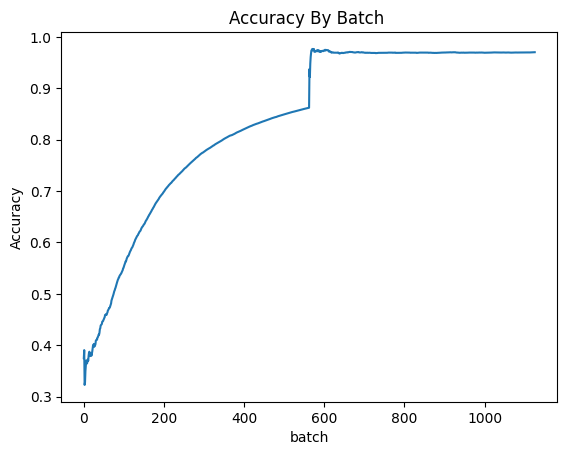

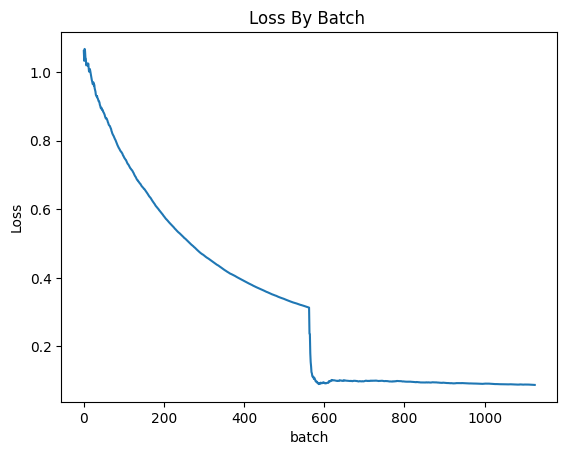

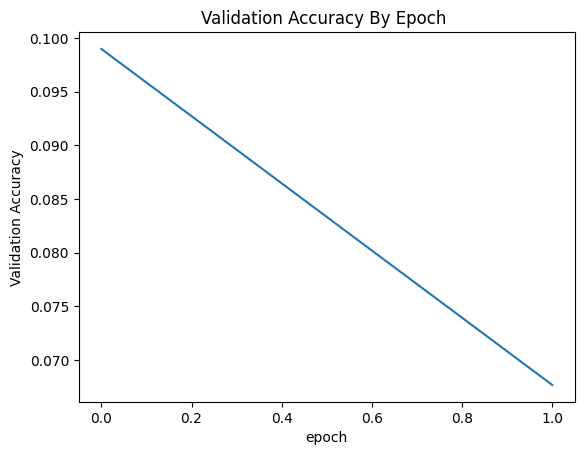

In [19]:
import matplotlib.pyplot as plt

plt.plot(accuracy_result, label='Accuracy')
plt.xlabel('batch')
plt.ylabel('Accuracy')
plt.title('Accuracy By Batch ')
plt.show()

plt.plot(loss_result, label='Loss')
plt.xlabel('batch')
plt.ylabel('Loss')
plt.title('Loss By Batch ')
plt.show()

plt.plot(history.history['val_loss'], label='Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy By Epoch ')
plt.show()

In [20]:
## Save the model which can be loaded later.
# model.save('my_model_keras', overwrite=True)

tf.saved_model.save(model,'my_model')

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [21]:
loss,accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.9770 - loss: 0.0674
Test accuracy : 0.9798000454902649
